In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# If i want to update stardist
import sys
import socket
from pystackreg import StackReg
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from skimage import filters
import numpy as np
from tifffile import imsave as tif_imsave
from tifffile import imwrite as tif_imwrite

from tifffile import imread as tif_imread
from csbdeep.utils import normalize

import matplotlib.pyplot as plt
import sys
from tqdm.auto import tqdm
sys.path.append('/home/oamsalem/code/Projects/EZfish')
sys.path.append('/home/oamsalem/code/Projects/EZfish')
sys.path.append(r'C:\Users\oamsalem\Projects\EZfish')

from sbxreader import sbx_memmap
import os
from pathlib import Path
from skimage.morphology import disk
from funs.par_funcs import regist_stack_parallel,filter_data_parallel
#import regist_stack_parallel

C:\ProgramData\Anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


# Reduction funcs

In [3]:
def set_reg_obj(reg_method):
    if reg_method =='AFFINE':
        sr = StackReg(StackReg.AFFINE)
    elif reg_method == 'RIGID_BODY':
        sr = StackReg(StackReg.RIGID_BODY)
    elif reg_method == '':
        return None
    else:
        raise Exception("Implement")
    return sr

def regist_stack(stack, filtered_stack, sr):
    if sr==None:
        return stack
    
    reg_stack = np.zeros_like(filtered_stack)
    #raise Exception("I have a bug herer, I am registering all planes per t, this is stupid!!")
    for pn in np.arange(filtered_stack.shape[1]):
        tmats = sr.register_stack(filtered_stack[:,pn].astype(np.float64), reference='mean')
        reg_stack[:,pn] = sr.transform_stack(stack[:,pn].astype(np.float64), tmats=tmats)
    return reg_stack

def filter_data(stack, filter_pipe):
    if filter_pipe == '':
        return stack.astype(np.float64)
    
    filtered_stack = stack.copy().astype(np.float64)

    for p in range(stack.shape[0]):
        for s in range(stack[p].shape[0]):
            img = stack[p][s]
            if 'guas' in filter_pipe:
                img = img - gaussian(img,filter_pipe['guas'])
            if 'med' in filter_pipe:
                img = img -  filters.median(img, disk(filter_pipe['med']))
            filtered_stack[p][s] = img
    return filtered_stack

def apply_func(stack,fun):
    if fun == 'mean':
        stack = np.mean(stack,0)
    if fun == 'max':
        stack = np.max(stack,0)
    if fun == 'median':
        stack = np.median(stack,0)
    return stack.astype(np.float32)

### Pick directory of sbx file(s) to process

In [4]:
# following up on tile movies

base_path = r'//NASQUATCH/data/2p/peter/chip_tiling/'

paths = ['211103_PZ1/chunks/PZ1_211103_well1_merge.sbx',
        '211103_PZ1/chunks/PZ1_211103_well2_merge.sbx',
        '211103_PZ1/chunks/PZ1_211103_well3_merge.sbx',
        '211103_PZ1/chunks/PZ1_211103_well4_merge.sbx',
        '211103_PZ1/chunks/PZ1_211103_well5_merge.sbx',
        '211103_PZ1/chunks/PZ1_211103_well6_merge.sbx',
        '211104_PZ1/chunks/PZ1_211104_well1_merge.sbx',
        '211104_PZ1/chunks/PZ1_211104_well2_merge.sbx',
        '211104_PZ1/chunks/PZ1_211104_well3_merge.sbx',
        '211104_PZ1/chunks/PZ1_211104_well4_merge.sbx',
        '211104_PZ1/chunks/PZ1_211104_well5_merge.sbx',
        '211104_PZ1/chunks/PZ1_211104_well6_merge.sbx',
        '211109_PZ1/chunks/PZ1_211109_well1_merge.sbx',
        '211109_PZ1/chunks/PZ1_211109_well2_merge.sbx',
        '211109_PZ1/chunks/PZ1_211109_well3_merge.sbx',
        '211109_PZ1/chunks/PZ1_211109_well4_merge.sbx',
        '211109_PZ1/chunks/PZ1_211109_well5_merge.sbx',
        '211109_PZ1/chunks/PZ1_211109_well6_merge.sbx',
        '211110_PZ1/chunks/PZ1_211110_well1_merge.sbx',
        '211110_PZ1/chunks/PZ1_211110_well2_merge.sbx',
        '211110_PZ1/chunks/PZ1_211110_well3_merge.sbx',
        '211110_PZ1/chunks/PZ1_211110_well4_merge.sbx',
        '211110_PZ1/chunks/PZ1_211110_well5_merge.sbx',
        '211110_PZ1/chunks/PZ1_211110_well6_merge.sbx',
        '211111_PZ1/chunks/PZ1_211111_well1_merge.sbx',
        '211111_PZ1/chunks/PZ1_211111_well2_merge.sbx',
        '211111_PZ1/chunks/PZ1_211111_well3_merge.sbx',
        '211111_PZ1/chunks/PZ1_211111_well4_merge.sbx',
        '211111_PZ1/chunks/PZ1_211111_well5_merge.sbx',
        '211111_PZ1/chunks/PZ1_211111_well6_merge.sbx',
        '211112_PZ1/chunks/PZ1_211112_well1_merge.sbx',
        '211112_PZ1/chunks/PZ1_211112_well2_merge.sbx',
        '211112_PZ1/chunks/PZ1_211112_well3_merge.sbx',
        '211112_PZ1/chunks/PZ1_211112_well4_merge.sbx',
        '211112_PZ1/chunks/PZ1_211112_well5_merge.sbx',
        '211112_PZ1/chunks/PZ1_211112_well6_merge.sbx',
        '211121_PZ1/chunks/PZ1_211121_well1_merge.sbx',
        '211121_PZ1/chunks/PZ1_211121_well2_merge.sbx',
        '211121_PZ1/chunks/PZ1_211121_well3_merge.sbx',
        '211121_PZ1/chunks/PZ1_211121_well4_merge.sbx',
        '211121_PZ1/chunks/PZ1_211121_well5_merge.sbx',
        '211121_PZ1/chunks/PZ1_211121_well6_merge.sbx',
        '211121_PZ1/chunks/PZ1_211121_well7_merge.sbx',
        '211121_PZ1/chunks/PZ1_211121_well8_merge.sbx',
        '211121_PZ1/chunks/PZ1_211121_well9_merge.sbx',
        '211123_PZ1/chunks/PZ1_211123_well1_merge.sbx',
        '211123_PZ1/chunks/PZ1_211123_well2_merge.sbx',
        '211123_PZ1/chunks/PZ1_211123_well3_merge.sbx',
        '211123_PZ1/chunks/PZ1_211123_well4_merge.sbx',
        '211123_PZ1/chunks/PZ1_211123_well5_merge.sbx',
        '211123_PZ1/chunks/PZ1_211123_well6_merge.sbx',
        '211123_PZ1/chunks/PZ1_211123_well7_merge.sbx',
        '211123_PZ1/chunks/PZ1_211123_well8_merge.sbx',
        '211123_PZ1/chunks/PZ1_211123_well9_merge.sbx']

bounds = [(0,796,0,512) for i in range(len(paths))]

jumps = np.repeat(10,len(bounds)).tolist()

In [4]:
# cleaning up mistakes in cutoffs!

base_path = r'//nasquatch/data/2p/peter/'

paths = ['in_vivo/220408_PK27PL20/PK27PL20_220408_101_full.sbx',
        'slice/20230824_SL1PL60/PL60_230824_001_full.sbx']

bounds = [(243,753,48,498),
          (145,655,15,465)]

jumps = np.repeat(52,len(bounds)).tolist()

In [4]:
# next batch(es) of paths prepared here

# david/dipping 6plex movies (211008 onward)
base_path = r'//anastasia/data/2p/david/'

paths = ['dipping_only/6plex/220304_PL7/PL7_220304_001_full.sbx',
        'dipping_only/6plex/220211_PK8/PK8_220211_001_full.sbx',
        'dipping_only/6plex/220210_PK7/PK7_220210_001_full.sbx',
        'dipping_only/6plex/220208_PK8/PK8_220208_001_full.sbx',
        'dipping_only/6plex/220207_PK5/PK5_220207_001_full.sbx',
        'dipping_only/6plex/220204_PK6/PK6_220204_001_full.sbx',
        'dipping_only/6plex/220203_PK9/PK9_220203_001_full.sbx',
        'dipping_only/6plex/220127_PK9/PK9_220127_001_full.sbx',
        'dipping_only/6plex/220126_PK8/PK8_220126_001_full.sbx',
        'dipping_only/6plex/220125_PK9/PK9_220125_001_full.sbx',
        'dipping_only/6plex/220121_PK8/PK8_220121_001_full.sbx',
        'dipping_only/6plex/220120_DT1/DT1_220120_001_full.sbx',
        'dipping_only/6plex/211222_PK8/PK8_211222_001_full.sbx',
        'dipping_only/6plex/211222_PK8/PK8_211222_101_full.sbx',
        'dipping_only/6plex/211222_PK8/PK8_211222_201_full.sbx',
        'dipping_only/6plex/211222_PK8/PK8_211222_301_full.sbx',
        'dipping_only/6plex/211221_PK7/PK7_211221_001_full.sbx',
        'dipping_only/6plex/211221_PK2/PK2_211221_001_full.sbx',
        'dipping_only/6plex/211221_PK2/PK2_211221_101_full.sbx',
        'dipping_only/6plex/211221_PK2/PK2_211221_201_full.sbx',
        'dipping_only/6plex/211215_DT2/DT2_211215_001_full.sbx',
        'dipping_only/6plex/211215_DT2/DT2_211215_101_full.sbx',
        'dipping_only/6plex/211214_PK6/PK6_211214_001_full.sbx',
        'dipping_only/6plex/211214_PK6/PK6_211214_101_full.sbx',
        'dipping_only/6plex/211213_PK5/PK5_211213_001_full.sbx',
        'dipping_only/6plex/211213_PK5/PK5_211213_101_full.sbx',
        'dipping_only/6plex/211210_PL4_warped/PL4_211210_001_full.sbx',
        'dipping_only/6plex/211210_PL3_bumped/PL3_211210_001_full.sbx',
        'dipping_only/6plex/211209_PK6/PK6_211209_001_full.sbx',
        'dipping_only/6plex/211209_PK6/PK6_211209_101_full.sbx',
        'dipping_only/6plex/211207_PK7/PK7_211207_001_full.sbx',
        'dipping_only/6plex/211203_PK7/PK7_211203_001_full.sbx',
        'dipping_only/6plex/211202_PK3/PK3_211202_001_full.sbx',
        'dipping_only/6plex/211124_PK2/PK2_211124_001_full.sbx',
        'dipping_only/6plex/211122_DT1/DT1_211122_001_full.sbx',
        'dipping_only/6plex/211027_DT2/DT2_211027_001_full.sbx',
        'dipping_only/6plex/211027_DT2/DT2_211027_100_full.sbx',
        'dipping_only/6plex/211026_DT2/DT2_211026_001_full.sbx',
        'dipping_only/6plex/211026_DT2/DT2_211026_100_full.sbx',
        'dipping_only/6plex/211022_PK5/PK5_211022_001_full.sbx',
        'dipping_only/6plex/211022_PK5/PK5_211022_100_full.sbx',
        'dipping_only/6plex/211021_PK3/PK3_211021_001_full.sbx',
        'dipping_only/6plex/211021_PK3/PK3_211021_100_full.sbx',
        'dipping_only/6plex/211009_PK4/PK4_211009_001_full.sbx',
        'dipping_only/6plex/211009_PK4/PK4_211009_501_full.sbx',
        'dipping_only/6plex/211008_PK4/PK4_211008_001_full.sbx',
        'dipping_only/6plex/211008_PK4/PK4_211008_501_full.sbx']

bounds = [(226,736,24,474),
         (90,600,31,481),
         (120,630,16,466),
         (169,679,16,466),
         (194,704,26,476),
         (211,721,26,476),
         (200,710,10,460),
         (120,630,15,465),
         (170,680,41,491),
         (75,585,37,487),
         (207,717,51,501),
         (137,647,34,484),
         (275,785,20,470),
         (265,775,20,470),
         (275,785,20,470),
         (285,795,20,470),
         (165,675,49,499),
         (132,642,19,469),
         (139,649,20,470),
         (125,635,30,480),
         (165,675,35,485),
         (190,700,40,490),
         (258,768,21,471),
         (285,795,22,472),
         (175,685,35,485),
         (160,670,45,495),
         (165,675,20,470),
         (135,645,30,480),
         (225,735,5,455),
         (220,730,5,455),
         (195,705,0,450),
         (140,650,30,480),
         (100,610,45,495),
         (130,640,15,465),
         (120,630,20,470),
         (0,510,10,460),
         (0,510,0,450),
         (50,560,20,470),
         (55,565,30,480),
         (270,780,0,450),
         (275,785,0,450),
         (135,645,15,465),
         (165,675,0,450),
         (195,705,60,510),
         (180,690,60,510),
         (190,700,20,470),
         (190,700,30,480)]

jumps = np.repeat(52,len(bounds)).tolist()

In [ ]:
paths = ['/Volumes/data/2p/peter/dipping/20230927_PL58/PL58_230927_001_full.sbx',
        '/Volumes/data/2p/peter/dipping/20230927_PL58/PL58_230927_101_full.sbx',
        '/Volumes/data/2p/peter/dipping/20230927_PL58/PL58_230927_201_full.sbx',
        '/Volumes/data/2p/peter/dipping/20230927_PL58/PL58_230927_301_full.sbx',
        '/Volumes/data/2p/peter/dipping/20230927_PL34/PL34_230927_001_full.sbx',
        '/Volumes/data/2p/peter/dipping/20230927_PL34/PL34_230927_101_full.sbx',
        '/Volumes/data/2p/peter/dipping/20230927_PL34/PL34_230927_201_full.sbx',
        '/Volumes/data/2p/peter/dipping/20230927_PL34/PL34_230927_301_full.sbx',
        '/Volumes/data/2p/peter/dipping/20230926_PL56/PL56_230926_001_full.sbx',
        '/Volumes/data/2p/peter/dipping/20230926_PL56/PL56_230926_101_full.sbx',
        '/Volumes/data/2p/peter/dipping/20230926_PL56/PL56_230926_201_full.sbx',
        '/Volumes/data/2p/peter/dipping/20230926_PL56/PL56_230926_301_full.sbx',
        '/Volumes/data/2p/peter/dipping/20230926_PL56/PL56_230926_401_full.sbx',
        '/Volumes/data/2p/peter/dipping/20230926_PL56/PL56_230926_501_full.sbx',
        '/Volumes/data/2p/peter/dipping/20230925_PL58/PL58_230925_001_full.sbx',
        '/Volumes/data/2p/peter/dipping/20230925_PL58/PL58_230925_101_full.sbx',
        '/Volumes/data/2p/peter/dipping/20230925_PL58/PL58_230925_201_full.sbx',
        '/Volumes/data/2p/peter/dipping/20230925_PL58/PL58_230925_301_full.sbx',
        '/Volumes/data/2p/peter/dipping/20230925_PL58/PL58_230925_401_full.sbx',
        '/Volumes/data/2p/peter/dipping/20230923_PL35/PL35_230923_001_full.sbx',
        '/Volumes/data/2p/peter/dipping/20230923_PL35/PL35_230923_101_full.sbx',
        '/Volumes/data/2p/peter/dipping/20230923_PL35/PL35_230923_201_full.sbx',
        '/Volumes/data/2p/peter/dipping/20230923_PL35/PL35_230923_301_full.sbx',
        '/Volumes/data/2p/peter/dipping/20230923_PL35/PL35_230923_401_full.sbx',
        '/Volumes/data/2p/peter/dipping/20230923_PL35/PL35_230923_501_full.sbx',
        '/Volumes/data/2p/peter/dipping/20230922_PL28/PL28_230922_001_full.sbx',
        '/Volumes/data/2p/peter/dipping/20230922_PL28/PL28_230922_101_full.sbx',
        '/Volumes/data/2p/peter/dipping/20230922_PL28/PL28_230922_201_full.sbx',
        '/Volumes/data/2p/peter/dipping/20230922_PL28/PL28_230922_301_full.sbx',
        '/Volumes/data/2p/peter/dipping/20230922_PL28/PL28_230922_401_full.sbx',
        '/Volumes/data/2p/peter/dipping/20230922_PL28/PL28_230922_501_full.sbx',
        '/Volumes/data/2p/peter/dipping/20230922_PL28/PL28_230922_601_full.sbx',
        '/Volumes/data/2p/peter/dipping/20230922_PL28/PL28_230922_701_full.sbx',
        '/Volumes/data/2p/peter/dipping/20230920_PL58/PL58_230920_001_full.sbx',
        '/Volumes/data/2p/peter/dipping/20230920_PL58/PL58_230920_101_full.sbx',
        '/Volumes/data/2p/peter/dipping/20230920_PL58/PL58_230920_201_full.sbx',
        '/Volumes/data/2p/peter/dipping/20230920_PL58/PL58_230920_301_full.sbx',
        '/Volumes/data/2p/peter/dipping/20230920_PL56/PL56_230920_001_full.sbx',
        '/Volumes/data/2p/peter/dipping/20230920_PL56/PL56_230920_101_full.sbx',
        '/Volumes/data/2p/peter/dipping/20230920_PL56/PL56_230920_201_full.sbx',
        '/Volumes/data/2p/peter/dipping/20230916_PL54/PL54_230916_001_full.sbx',
        '/Volumes/data/2p/peter/dipping/20230916_PL54/PL54_230916_101_full.sbx',
        '/Volumes/data/2p/peter/dipping/20230916_PL54/PL54_230916_201_full.sbx',
        '/Volumes/data/2p/peter/dipping/20230916_PL54/PL54_230916_301_full.sbx',
        '/Volumes/data/2p/peter/dipping/20230916_PL54/PL54_230916_401_full.sbx',
        '/Volumes/data/2p/peter/dipping/20230916_PL54/PL54_230916_501_full.sbx',
        '/Volumes/data/2p/peter/dipping/20230916_PL48/PL48_230916_001_full.sbx',
        '/Volumes/data/2p/peter/dipping/20230916_PL48/PL48_230916_101_full.sbx',
        '/Volumes/data/2p/peter/dipping/20230915_PL52/PL52_230915_001_full.sbx',
        '/Volumes/data/2p/peter/dipping/20230915_PL52/PL52_230915_101_full.sbx',
        '/Volumes/data/2p/peter/dipping/20230915_PL52/PL52_230915_201_full.sbx',
        '/Volumes/data/2p/peter/dipping/20230915_PL52/PL52_230915_301_full.sbx',
        '/Volumes/data/2p/peter/dipping/20230915_PL52/PL52_230915_401_full.sbx',
        '/Volumes/data/2p/peter/dipping/20230825_PL57/PL57_230825_001_full.sbx',
        '/Volumes/data/2p/peter/dipping/20230825_PL39/PL39_230825_001_full.sbx',
        '/Volumes/data/2p/peter/dipping/20230823_PL61/PL61_230823_001_full.sbx',
        '/Volumes/data/2p/peter/dipping/20230823_PL48/PL48_230823_001_full.sbx',
        '/Volumes/data/2p/peter/dipping/20230823_PL28/PL28_230823_001_full.sbx',
        '/Volumes/data/2p/peter/dipping/20230823_PL28/PL28_230823_101_full.sbx',
        '/Volumes/data/2p/peter/dipping/20230823_PL28/PL28_230823_201_full.sbx',
        '/Volumes/data/2p/peter/dipping/20230821_PL57/PL57_230821_001_full.sbx',
        '/Volumes/data/2p/peter/dipping/20230819_PL62/PL62_230819_001_full.sbx',
        '/Volumes/data/2p/peter/dipping/20230819_PL43/PL43_230819_001_full.sbx',
        '/Volumes/data/2p/peter/dipping/20230819_PL43/PL43_230819_101_full.sbx',
        '/Volumes/data/2p/peter/dipping/20230819_PL43/PL43_230819_201_full.sbx']

bounds = [(173,683,2,452),
         (180,690,20,470),
         (160,670,0,450),
         (165,675,10,460),
         (124,634,0,450),
         (69,579,6,456),
         (127,637,13,463),
         (222,732,23,473),
         (171,681,13,463),
         (177,687,4,454),
         (110,620,53,503),
         (191,701,13,463),
         (187,697,11,461),
         (172,682,9,459),
         (160,670,7,457),
         (118,628,11,461),
         (117,627,17,467),
         (158,668,16,468),
         (152,662,0,450),
         (191,701,26,476),
         (189,699,19,469),
         (115,625,22,472),
         (129,639,22,472),
         (194,704,11,461),
         (187,697,0,450),
         (175,685,11,461),
         (165,675,16,466),
         (128,638,16,466),
         (143,653,20,470),
         (147,657,19,469),
         (143,653,9,459),
         (164,674,13,463),
         (165,675,19,469),
         (118,628,18,468),
         (117,627,36,486),
         (171,681,37,487),
         (129,639,7,457),
         (159,669,21,471),
         (122,632,48,498),
         (171,681,18,468),
         (202,712,2,452),
         (141,651,5,455),
         (140,650,13,463),
         (110,620,16,466),
         (195,705,8,458),
         (185,695,4,454),
         (109,619,7,457),
         (230,740,13,463),
         (156,663,3,453),
         (132,642,19,469),
         (160,670,24,474),
         (164,674,28,478),
         (168,678,24,474),
         (90,600,25,475),
         (145,655,15,465),
         (198,708,0,450),
         (250,760,40,490),
         (170,680,10,460),
         (161,671,2,452),
         (161,671,36,486),
         (115,625,0,450),
         (205,715,20,470),
         (175,685,20,470),
         (176,686,11,461),
         (166,676,0,450)]

In [4]:
# final peter/dipping movies (all 2022)
base_path = r'//nasquatch/data/2p/peter/'

paths = ['dipping/20221129_PL28/PL28_221129_001_full.sbx',
        'dipping/20221129_PL28/PL28_221129_101_full.sbx',
        'dipping/20221118_PL28/PL28_221118_001_full.sbx',
        'dipping/20221116_PL44/PL44_221116_001_full.sbx',
        'dipping/20221115_PL42/PL42_221115_001_full.sbx',
        'dipping/20221115_PL42/PL42_221115_101_full.sbx',
        'dipping/20221115_PL42/PL42_221115_201_full.sbx',
        'dipping/20221104_PL45/PL45_221104_001_full.sbx',
        'dipping/20221103_PL47/PL47_221103_001_full.sbx',
        'dipping/20221103_PL38/PL38_221103_001_full.sbx',
        'dipping/20221102_PL44/PL44_221102_001_full.sbx',
        'dipping/20221102_PL44/PL44_221102_101_full.sbx',
        'dipping/20221101_PL42/PL42_221101_001_full.sbx',
        'dipping/20221101_PL42/PL42_221101_101_full.sbx',
        'dipping/20221014_PL36/PL36_221014_001_full.sbx',
        'dipping/20221014_PL36/PL36_221014_101_full.sbx',
        'dipping/20221013_PL33/PL33_221013_001_full.sbx',
        'dipping/20221013_PL33/PL33_221013_101_full.sbx',
        'dipping/20220930_PL34/PL34_220930_001_full.sbx',
        'dipping/20220930_PL34/PL34_220930_101_full.sbx',
        'dipping/20220921_PL25/PL25_220921_001_full.sbx',
        'dipping/20220921_PL25/PL25_220921_101_full.sbx',
        'dipping/20220915_PL29/PL29_220915_001_full.sbx',
        'dipping/20220915_PL29/PL29_220915_101_full.sbx',
        'dipping/20220914_PL21/PL21_220914_001_full.sbx',
        'dipping/20220914_PL21/PL21_220914_101_full.sbx',
        'dipping/20220907_PL27/PL27_220907_001_full.sbx',
        'dipping/20220907_PL27/PL27_220907_101_full.sbx',
        'dipping/20220906_PL24/PL24_220906_001_full.sbx',
        'dipping/20220906_PL24/PL24_220906_101_full.sbx',
        'dipping/20220831_PL31/PL31_220831_001_full.sbx',
        'dipping/20220831_PL27/PL27_220831_001_full.sbx',
        'dipping/20220830_PL32/PL32_220830_001_full.sbx',
        'dipping/20220830_PL24/PL24_220830_001_full.sbx',
        'dipping/20220825_PL29/PL29_220825_001_full.sbx',
        'dipping/20220825_PL18/PL18_220825_001_full.sbx',
        'dipping/20220824_PL33/PL33_220824_001_full.sbx',
        'dipping/20220824_PL13/PL13_220824_001_full.sbx',
        'dipping/20220823_PL32/PL32_220823_001_full.sbx',
        'dipping/20220823_PL24/PL24_220823_001_full.sbx',
        'dipping/20220819_PL23/PL23_220819_001_full.sbx',
        'dipping/20220819_PL22/PL22_220819_001_full.sbx',
        'dipping/20220817_PL31/PL31_220817_001_full.sbx',
        'dipping/20220817_PL27/PL27_220817_001_full.sbx',
        'dipping/20220816_PL24/PL24_220816_001_full.sbx',
        'dipping/20220812_PL28/PL28_220812_001_full.sbx',
        'dipping/20220812_PL22/PL22_220812_001_full.sbx',
        'dipping/20220811_PL30/PL30_220811_001_full.sbx',
        'dipping/20220811_PL18/PL18_220811_001_full.sbx',
        'dipping/20220810_PL27/PL27_220810_001_full.sbx',
        'dipping/20220810_PL20/PL20_220810_001_full.sbx',
        'dipping/20220809_PL24/PL24_220809_001_full.sbx',
        'dipping/20220809_PL14/PL14_220809_001_full.sbx',
        'dipping/20220729_PL27/PL27_220729_001_full.sbx',
        'dipping/20220728_PL24/PL24_220728_001_full.sbx',
        'dipping/20220727_PL14/PL14_220727_001_full.sbx',
        'dipping/20220707_PL18/PL18_220707_001_full.sbx',
        'dipping/20220705_PL9/PL9_220705_001_full.sbx']

bounds = [(147,657,27,477),
         (155,665,25,475),
         (153,663,20,470),
         (146,656,35,485),
         (160,670,20,470),
         (180,690,30,480),
         (202,712,25,475),
         (182,692,32,482),
         (185,695,25,475),
         (183,693,30,480),
         (145,655,43,493),
         (170,680,15,465),
         (150,660,16,466),
         (185,695,10,460),
         (155,665,16,466),
         (130,640,10,460),
         (111,621,4,454),
         (120,630,15,465),
         (209,719,25,475),
         (215,725,15,465),
         (160,670,25,475),
         (185,695,40,490),
         (189,699,32,482),
         (190,700,30,480),
         (165,675,24,474),
         (127,637,6,456),
         (183,693,21,471),
         (170,680,40,490),
         (182,692,18,468),
         (130,640,5,455),
         (136,646,30,480),
         (207,717,10,460),
         (177,687,49,499),
         (138,648,23,473),
         (194,704,21,471),
         (202,712,34,484),
         (167,677,29,479),
         (150,660,8,458),
         (241,751,35,485),
         (139,649,33,483),
         (196,706,11,461),
         (116,626,4,454),
         (121,631,28,478),
         (187,697,0,450),
         (249,759,20,470),
         (166,676,27,477),
         (152,662,49,499),
         (143,653,31,481),
         (147,657,19,469),
         (179,689,35,485),
         (185,695,5,455),
         (173,683,2,452),
         (97,607,21,471),
         (160,670,40,490),
         (153,663,49,499),
         (241,751,23,473),
         (154,664,30,480),
         (196,706,17,467)]

jumps = np.repeat(52,len(bounds)).tolist()

In [4]:
# final in vivo movies (up to 2022 7/1)
base_path = r'//nasquatch/data/2p/peter/'

paths = ['in_vivo/220701_PK49PL18/PK49PL18_220701_001_noartifact.sbx',
        'in_vivo/220701_PK49PL18/PK49PL18_220701_101_full.sbx',
        'in_vivo/220629_PK46PL25/PK46PL25_220629_001_noartifact.sbx',
        'in_vivo/220629_PK46PL25/PK46PL25_220629_101_full.sbx',
        'in_vivo/220628_PK45PL24/PK45PL24_220628_001_noartifact.sbx',
        'in_vivo/220624_PK45PL13/PK45PL13_220624_001_noartifact.sbx',
        'in_vivo/220624_PK45PL13/PK45PL13_220624_101_full.sbx',
        'in_vivo/220622_PK44PL17/PK44PL17_220622_001_noartifact.sbx',
        'in_vivo/220622_PK44PL17/PK44PL17_220622_101_full.sbx',
        'in_vivo/220621_PK24PL13/PK24PL13_220621_001_noartifact.sbx',
        'in_vivo/220621_PK24PL13/PK25PL13_220621_101_full.sbx',
        'in_vivo/220617_PK26PL18/PK26PL18_220617_001_noartifact.sbx',
        'in_vivo/220617_PK26PL18/PK26PL18_220617_101_full.sbx',
        'in_vivo/220616_PK25PL9/PK25PL9_220616_001_noartifact.sbx',
        'in_vivo/220615_PK24PL18/PK24PL18_220615_001_noartifact.sbx',
        'in_vivo/220530_PK25PL9/PK25PL9_220530_001_noartifact.sbx',
        'in_vivo/220530_PK25PL9/PK25PL9_220530_101_full.sbx',
        'in_vivo/220519_PK43PL17/PK43PL17_220519_001_noartifact.sbx',
        'in_vivo/220519_PK43PL17/PK43PL17_220519_101_full.sbx',
        'in_vivo/220518_PK40PL14/PK40PL14_220518_001_noartifact.sbx',
        'in_vivo/220515_PK27PL13/PK27PL13_220515_001_noartifact.sbx',
        'in_vivo/220514_PK26PL6/PK26PL6_220514_001_noartifact.sbx',
        'in_vivo/220514_PK26PL6/PK26PL6_220514_101_full.sbx',
        'in_vivo/220512_PK24PL19/PK24PL19_220512_001_noartifact.sbx',
        'in_vivo/220506_PK26PL16/PK26PL16_220506_001_noartifact.sbx',
        'in_vivo/220504_PK24PL9/PK24PL9_220504_001_noartifact.sbx',
        'in_vivo/220504_PK24PL9/PK24PL9_220504_101_full.sbx',
        'in_vivo/220427_PK27PL20/PK27PL20_220427_001_noartifact.sbx',
        'in_vivo/220427_PK27PL20/PK27PL20_220427_101_full.sbx',
        'in_vivo/220423_PK24PL17/PK24PL17_220423_001_noartifact.sbx',
        'in_vivo/220407_PK26PL15/PK26PL15_220407_001_noartifact.sbx',
        'in_vivo/220407_PK26PL15/PK26PL15_220407_101_full.sbx',
        'in_vivo/220406_PK24PL10/PK24PL10_220406_001_noartifact.sbx',
        'in_vivo/220406_PK24PL10/PK24PL10_220406_101_full.sbx',
        'in_vivo/220318_PK24PL14/PK24PL14_220318_001_noartifact.sbx',
        'in_vivo/220318_PK24PL14/PK24PL14_220318_101_full.sbx',
        'in_vivo/220316_PK32PL13/PK32PL13_220316_001_noartifact.sbx',
        'in_vivo/220316_PK32PL13/PK32PL13_220316_101_full.sbx',
        'in_vivo/220315_PK36PL18/PK36PL18_220315_001_noartifact.sbx',
        'in_vivo/220315_PK36PL18/PK36PL18_220315_101_full.sbx',
        'in_vivo/220314_PL14BCH/PL14BCH_220314_001_full.sbx',
        'in_vivo/220311_PK24PL9/PK24PL9_220311_001_noartifact.sbx',
        'in_vivo/220311_PK24PL9/PK24PL9_220311_101_full.sbx',
        'in_vivo/220303_PK26PL21/PK26PL21_220303_001_noartifact.sbx',
        'in_vivo/220303_PK26PL21/PK26PL21_220303_101_full.sbx',
        'in_vivo/220302_PK27PL13/PK27PL13_220302_001_noartifact.sbx',
        'in_vivo/220223_PK26PL19/PK26PL19_220223_001_noartifact.sbx',
        'in_vivo/220217_PK27PL13/PK27PL13_220217_001_noartifact.sbx',
        'in_vivo/220217_PK26PL15/PK26PL15_220217_001_noartifact.sbx',
        'in_vivo/220216_PK25PL8/PK25PL8_220216_001_noartifact.sbx',
        'in_vivo/220216_PK25PL8/PK25PL8_220216_101_full.sbx']

bounds = [(142,652,34,484),
         (200,710,35,485),
         (151,661,42,492),
         (180,690,25,475),
         (143,653,26,476),
         (154,664,31,481),
         (181,691,21,471),
         (153,663,30,480),
         (148,658,30,480),
         (156,666,33,483),
         (145,655,20,470),
         (151,661,22,472),
         (195,705,20,470),
         (147,657,21,471),
         (145,655,26,476),
         (138,648,31,481),
         (205,715,15,465),
         (145,655,32,482),
         (167,677,64,514),
         (159,669,23,473),
         (148,658,42,492),
         (145,655,27,477),
         (200,710,20,470),
         (157,667,38,488),
         (149,659,32,482),
         (158,668,43,493),
         (146,656,27,477),
         (152,662,39,489),
         (209,719,53,503),
         (142,652,44,494),
         (139,649,37,487),
         (144,654,14,464),
         (150,660,30,480),
         (179,689,25,475),
         (153,663,37,487),
         (95,605,33,483),
         (157,667,31,481),
         (173,683,43,493),
         (161,671,38,488),
         (85,595,43,493),
         (90,600,62,512),
         (137,647,44,494),
         (259,769,15,465),
         (150,660,37,487),
         (182,692,27,477),
         (138,648,40,490),
         (149,659,30,480),
         (125,635,41,491),
         (144,654,35,485),
         (144,654,40,490),
         (84,594,37,487)]

jumps = np.repeat(52,len(bounds)).tolist()

In [46]:
# next in vivo movies (2022 9/1 - 2023 8/10)
base_path = r'//nasquatch/data/2p/peter/'

paths = ['in_vivo/230810_DG87PL55/DG87PL55_230810_001_noartifact.sbx',
        'in_vivo/230810_DG87PL55/DG87PL55_230810_101_full.sbx',
        'in_vivo/230809_DG86PL57/DG86PL57_230809_001_noartifact.sbx',
        'in_vivo/230809_DG86PL57/DG86PL57_230809_101_full.sbx',
        'in_vivo/230808_DG85PL61/DG85PL61_230808_001_noartifact.sbx',
        'in_vivo/230808_DG85PL61/DG85PL61_230808_101_full.sbx',
        'in_vivo/230807_DG84PL52/DG84PL52_230807_001_noartifact.sbx',
        'in_vivo/230807_DG84PL52/DG84PL52_230807_101_full.sbx',
        'in_vivo/230802_DG48PL58/DG48PL58_230802_001_noartifact.sbx',
        'in_vivo/230802_DG48PL58/DG48PL58_230802_101_full.sbx',
        'in_vivo/230728_DG80PL57/DG80PL57_230728_001_noartifact.sbx',
        'in_vivo/230727_DG79PL59/DG79PL59_230727_001_noartifact.sbx',
        'in_vivo/230726_DG47PL54/DG47PL54_230726_001_noartifact.sbx',
        'in_vivo/230726_DG47PL54/DG47PL54_230726_101_full.sbx',
        'in_vivo/230721_DG46PL32/DG46PL32_230721_001_noartifact.sbx',
        'in_vivo/230721_DG46PL32/DG46PL32_230721_101_full.sbx',
        'in_vivo/230720_PK97PL48/PK97PL48_230720_001_noartifact.sbx',
        'in_vivo/230720_PK97PL48/PK97PL48_230720_101_full.sbx',
        'in_vivo/230714_PK95PL55/PK95PL55_230714_001_noartifact.sbx',
        'in_vivo/230713_PK94PL59/PK94PL59_230713_001_noartifact.sbx',
        'in_vivo/230713_PK94PL59/PK94PL59_230713_101_full.sbx',
        'in_vivo/230712_PK93PL57/PK93PL57_230712_001_noartifact.sbx',
        'in_vivo/230712_PK93PL57/PK93PL57_230712_101_full.sbx',
        'in_vivo/230711_DG44PL47/DG44PL47_230711_001_noartifact.sbx',
        'in_vivo/230711_DG44PL47/DG44PL47_230711_101_full.sbx',
        'in_vivo/230711_DG43PL32/DG43PL32_230711_001_noartifact.sbx',
        'in_vivo/230708_DG70PL56/DG70PL56_230708_001_noartifact.sbx',
        'in_vivo/230708_DG70PL56/DG70PL56_230708_101_full.sbx',
        'in_vivo/230707_DG72PL32/DG72PL32_230707_001_noartifact.sbx',
        'in_vivo/230707_DG72PL32/DG72PL32_230707_101_full.sbx',
        'in_vivo/230706_DG71PL54/DG71PL54_230706_001_noartifact.sbx',
        'in_vivo/230706_DG71PL54/DG71PL54_230706_002.sbx',#mouse2??
        'in_vivo/230706_DG71PL54/DG71PL54_230706_101_full.sbx',
        'in_vivo/230617_DG70PL54/DG70PL54_230617_001_noartifact.sbx',
        'in_vivo/230617_DG70PL54/DG70PL54_230617_101_full.sbx',
        'in_vivo/230615_DG69PL32/DG69PL32_230615_001_noartifact.sbx',
        'in_vivo/230615_DG69PL32/DG69PL32_230615_101_full.sbx',
        'in_vivo/230614_DG63PL54/DG63PL54_230614_001_noartifact.sbx',
        'in_vivo/230614_DG63PL54/DG63PL54_230614_101_full.sbx',
        'in_vivo/230601_PK85PL53/PK85PL53_230601_001_noartifact.sbx',
        'in_vivo/230601_PK85PL53/PL53_230601_101_full.sbx',
        'in_vivo/230531_PK80PL43/PK80PL43_230531_001_noartifact.sbx',
        'in_vivo/230531_PK80PL43/PL43_230531_101_full.sbx',
        'in_vivo/230526_PK84PL50/PK84PL50_230526_001_noartifact.sbx',
        'in_vivo/230526_PK84PL50/PL50_230526_101_full.sbx',
        'in_vivo/230525_DG42PL39/DG42PL39_230525_001_noartifact.sbx',
        'in_vivo/230525_DG42PL39/PL39_230525_101_full.sbx',
        'in_vivo/230519_DG41PL52/DG41PL52_230519_001_noartifact.sbx',
        'in_vivo/230519_DG41PL52/PL52_230519_101_full.sbx',
        'in_vivo/221204_PS39PL51/PS39PL51_221204_001_noartifact.sbx',
        'in_vivo/221204_PS39PL51/PS39PL51_221204_101_full.sbx',
        'in_vivo/221203_PS45PL50/PS45PL50_221203_001_noartifact.sbx',
        'in_vivo/221203_PS45PL50/PS45PL50_221203_101_full.sbx',
        'in_vivo/221125_PS39PL50/PS39PL50_221125_001_noartifact.sbx',
        'in_vivo/221125_PS39PL50/PS39PL50_221125_101_full.sbx',
        'in_vivo/221111_PS28PL41/PS28PL41_221111_001_noartifact.sbx',
        'in_vivo/221111_PS28PL41/PS28PL41_221111_101_full.sbx',
        'in_vivo/221109_PS27PL28/PS27PL28_221109_0011_noartifact.sbx',
        'in_vivo/221109_PS27PL28/PS27PL28_221109_001_full.sbx',
        'in_vivo/221107_PS23PL42/PS23PL42_221107_001_noartifact.sbx',
        'in_vivo/221020_PS16PL39/PS16PL39_221020_001_noartifact.sbx',
        'in_vivo/221020_PS16PL39/PS16PL39_221020_101_full.sbx',
        'in_vivo/221018_PS10PL24/PS10PL24_221018_001_noartifact.sbx',
        'in_vivo/221018_PS10PL24/PS10PL24_221018_101_full.sbx',
        'in_vivo/220929_PS11PL37/PS11PL37_220929_001_noartifact.sbx',
        'in_vivo/220928_PK65PL30/PK65PL30_220928_001_noartifact.sbx',
        'in_vivo/220927_PK60PL33/PK60PL33_220927_001_noartifact.sbx',
        'in_vivo/220916_PK66PL28/PK66PL28_220916_001_noartifact.sbx',
        'in_vivo/220916_PK66PL28/PK66PL28_220916_101_full.sbx',
        'in_vivo/220913_PK65PL32/PK65PL32_220913_001_noartifact.sbx',
        'in_vivo/220903_PK63PL34/PK63PL34_220903_001_noartifact.sbx',
        'in_vivo/220903_PK63PL34/PK63PL34_220903_101_full.sbx',
        'in_vivo/220902_PK61PL37/PK61PL37_220902_001_noartifact.sbx',
        'in_vivo/220902_PK61PL37/PPK61PL37_220902_101_full.sbx',
        'in_vivo/220901_PK60PL36/PK60PL36_220901_001_noartifact.sbx',
        'in_vivo/220901_PK60PL36/PK60PL36_220901_101_full.sbx']

bounds = [(140,650,35,485),
         (185,695,0,450),
         (136,646,30,480),
         (139,649,31,481),
         (128,638,32,482),
         (193,703,33,483),
         (123,633,32,482),
         (136,646,60,510),
         (136,646,33,483),
         (147,657,25,475),
         (145,655,18,468),
         (134,644,33,483),
         (136,646,24,474),
         (238,748,21,471),
         (148,658,34,484),
         (195,705,10,460),
         (149,659,31,481),
         (204,714,39,489),
         (135,645,31,481),
         (131,641,26,476),
         (227,737,34,484),
         (148,658,38,488),
         (160,670,10,460),
         (134,644,37,487),
         (220,730,0,450),
         (160,670,30,480),
         (137,647,20,470),
         (190,700,10,460),
         (150,660,31,481),
         (126,636,20,470),
         (159,669,31,481),
         (165,675,40,490),
         (165,675,35,485),
         (146,656,29,479),
         (165,675,40,490),
         (155,665,33,483),
         (109,619,20,470),
         (155,665,47,497),
         (170,680,15,465),
         (134,644,48,498),
         (150,660,10,460),
         (138,648,42,492),
         (200,710,25,475),
         (161,671,42,492),
         (225,735,26,476),
         (142,652,25,475),
         (200,710,10,460),
         (167,677,41,491),
         (167,677,48,498),
         (138,648,33,483),
         (145,655,40,490),
         (131,641,45,495),
         (150,660,40,490),
         (140,650,35,485),
         (160,670,30,480),
         (133,643,30,480),
         (170,680,35,485),
         (126,636,33,483),
         (195,705,35,485),
         (165,675,20,470),
         (133,643,34,484),
         (234,744,0,450),
         (135,645,33,483),
         (206,716,55,505),
         (152,662,27,477),
         (149,659,15,465),
         (160,670,29,479),
         (129,639,40,490),
         (175,685,50,500),
         (134,644,43,493),
         (176,686,35,485),
         (91,601,48,498),
         (156,666,14,464),
         (160,670,20,470),
         (146,656,33,483),
         (182,692,39,489)]

jumps = np.repeat(52,len(bounds)).tolist()

In [58]:
# slice movies (running 12/19/23 11am)

## remember to adjust loop to account for multiple dippings!!
base_path = r'//nasquatch/data/2p/peter/'

paths = ['slice/20230831_SL1PL55/PL55_230831_001_full.sbx',
        'slice/20230831_SL1PL55/SL1PL55_230831_001_noartifact.sbx',
        'slice/20230830_SL2PL60/SL2PL60_230830_001_noartifact.sbx',
        'slice/20230830_SL1PL28/PL28_230830_001_full.sbx',
        'slice/20230830_SL1PL28/SL1PL28_230830_001_noartifact.sbx',
        'slice/20230829_SL3PL61/SL3PL61_230829_001_noartifact.sbx',
        'slice/20230829_SL2PL39/SL2PL39_230829_001_noartifact.sbx',
        'slice/20230829_SL1PL56/PL56_230829_001_full.sbx',
        'slice/20230829_SL1PL56/SL1PL56_230829_001_noartifact.sbx',
        'slice/20230824_SL2PL54/SL2PL54_230824_001_noartifact.sbx',
        'slice/20230824_SL1PL60/PL60_230824_001_full.sbx',
        'slice/20230824_SL1PL60/PL60_230824_101_full.sbx',
        'slice/20230824_SL1PL60/SL1PL60_230824_001_noartifact.sbx',
        'slice/20230822_SL3PL58/SL3PL58_230822_001_noartifact.sbx',
        'slice/20230822_SL2PL52/PL52_230822_001_full.sbx',
        'slice/20230822_SL2PL52/SL2PL52_230822_001_noartifact.sbx',
        'slice/20230822_SL1PL32/SL1PL32_230822_001_noartifact.sbx',
        'slice/20230817_SL2PL60/SL2PL60_230817_001_noartifact.sbx',
        'slice/20230817_SL1PL55/PL55_230817_001_full.sbx',
        'slice/20230817_SL1PL55/PL55_230817_101_full.sbx',
        'slice/20230817_SL1PL55/SL1PL55_230817_001_noartifact.sbx',
        'slice/20230801_SL2PL34/SL2PL34_230801_001_noartifact.sbx', #from here onward, definitely stop ch1 since no tdTomato!
        'slice/20230801_SL1PL35/PL35_230801_101_full.sbx',
        'slice/20230801_SL1PL35/SL1PL35_230801_001_noartifact.sbx',
        'slice/20230727_SL2PL32/PL32_230727_101_full.sbx',
        'slice/20230727_SL2PL32/SL2PL32_230727_001_noartifact.sbx',
        'slice/20230727_SL1PL52/SL1PL52_230727_001_noartifact.sbx',
        'slice/20230616_SL2PL39/SL2PL39_230616_001.sbx',
        'slice/20230616_SL1PL28/PL28_230616_001_full.sbx',
        'slice/20230616_SL1PL28/SL1PL28_230616_001.sbx',
        'slice/20230608_SL2PL45/SL2PL45_230608_001_noartifact.sbx',
        'slice/20230608_SL1PL37/SL1PL37_230608_001_noartifact.sbx',
        'slice/20230607_SL2PL42/SL2PL42_230607_001_noartifact.sbx',
        'slice/20230607_SL1PL47/PL47_230607_001_full.sbx',
        'slice/20230607_SL1PL47/SL1PL47_230607_001.sbx',
        'slice/20230606_SL1PL35/PL35_230606_001.sbx',
        'slice/20230606_SL1PL35/SL1PL35_230606_001.sbx',
        'slice/20230511_DA2PL45/xx0DA2PL45_230511_001.sbx',
        'slice/20230511_DA1PL37/PL37_230511_101_full.sbx',
        'slice/20230511_DA1PL37/xx0DA1PL37_230511_001.sbx',
        'slice/20230509_DA2PL55/DA2PL55_230509_001.sbx',
        'slice/20230509_DA1PL53/DA1PL53_230509_001.sbx',
        'slice/20230509_DA1PL53/PL53_230509_101_full.sbx']

bounds = [(155,665,20,470),
         (150,660,30,480),
         (265,775,31,481),
         (190,700,25,475),
         (56,566,33,483),
         (81,591,35,485),
         (160,670,0,450),
         (200,710,15,465),
         (153,663,0,450),
         (145,655,30,480),
         (145,655,16,465), #mistake! should be 15 not 16!
         (180,690,20,470),
         (135,645,25,475),
         (155,665,0,450),
         (195,705,10,460),
         (128,638,13,463),
         (116,626,53,503),
         (160,670,45,495),
         (220,730,0,450),
         (165,675,20,470),
         (140,650,45,495),
         (139,700,0,495),
         (210,720,13,463),
         (53,614,0,495),
         (135,645,46,496),
         (234,744,62,512),
         (98,608,0,450),
         (102,663,12,507),
         (230,791,0,495),
         (113,674,3,498),
         (78,639,17,512),
         (95,656,0,495),
         (75,636,11,506),
         (147,708,13,508),
         (96,657,14,509),
         (97,658,0,495),
         (173,734,13,508),
         (209,719,54,504),
         (137,647,41,491),
         (152,662,22,472),
         (152,662,23,473),
         (222,732,0,450),
         (177,738,13,508)]

jumps = [52,
        52,
        52,
        52,
        52,
        52,
        52,
        52,
        52,
        52,
        52,
        52,
        52,
        52,
        52,
        52,
        52,
        52,
        52,
        52,
        52,
        52,
        52,
        52,
        52,
        52,
        52,
        52,
        52,
        52,
        52,
        52,
        52,
        52,
        52,
        52,
        52,
        52,
        52,
        52,
        52,
        52,
        52]


In [4]:
# DONE 12/19/23 10am
# not sure if I want to create an sbx file before or load the sbxs 100-X
#base_path = Path(r'//nasquatch/data/2p/peter/')
base_path = r'//nasquatch/data/2p/peter/'
#exp_folder = base_path /'in_vivo/220408_PK27PL20'
#
#sbxs = list(range(101,178)) # which SBX files to run <-- add an extra value to the end (1,n+1).
#sbxs = ['101_full']
#sbxs = ['001_aligned']
#sbxs = ['001_noartifact']

paths = ['in_vivo/231108_DG61PL62/DG61PL62_231108_001_noartifact.sbx',
        'in_vivo/231108_DG61PL62/DG61PL62_231108_101_full.sbx',
        'in_vivo/231107_DG44PL58/DG44PL58_231107_001_noartifact.sbx',
        'in_vivo/231107_DG44PL58/DG44PL58_231107_101_full.sbx',
        'in_vivo/231106_DG52PL68/DG52PL68_231106_001_noartifact.sbx',
        'in_vivo/231106_DG52PL68/DG52PL68_231106_101_full.sbx',
        'in_vivo/231105_DG39PL32/DG39PL32_231105_001_noartifact.sbx',
        'in_vivo/231105_DG39PL32/DG39PL32_231105_201_full.sbx',
        'in_vivo/231105_DG43PL32/DG43PL32_231105_001_noartifact.sbx',
        'in_vivo/231031_DG53PL28/DG53PL28_231031_001_noartifact.sbx',
        'in_vivo/231031_DG53PL28/DG53PL28_231031_101_full.sbx',
        'in_vivo/231030_DG60PL67/DG60PL67_231030_001_noartifact.sbx',
        'in_vivo/231030_DG60PL67/DG60PL67_231030_101_full.sbx',
        'in_vivo/231029_DG58PL64/DG58PL64_231029_001_noartifact.sbx',
        'in_vivo/231027_DG57PL69/DG57PL69_231027_001_noartifact.sbx',
        'in_vivo/231024_DG54PL61/DG54PL61_231024_001_noartifact.sbx',
        'in_vivo/231024_DG54PL61/DG54PL61_231024_101_full.sbx',
        'in_vivo/231019_DG53PL68/DG53PL68_231019_001_noartifact.sbx',
        'in_vivo/231018_DG52PL66/DG52PL66_231018_001_noartifact.sbx',
        'in_vivo/231018_DG52PL66/DG52PL66_231018_101_full.sbx',
        'in_vivo/231017_DG49PL70/DG49PL70_231017_001_noartifact.sbx',
        'in_vivo/230909_DG88PL58/DG88PL58_230909_001_noartifact.sbx',
        'in_vivo/230909_DG88PL58/DG88PL58_230909_101_full.sbx',
        'in_vivo/230908_PK109PL52/PK109PL52_230908_001_noartifact.sbx',
        'in_vivo/230908_PK109PL52/PK109PL52_230908_101_full.sbx',
        'in_vivo/230907_PK108PL54/PK108PL54_230907_001_noartifact.sbx',
        'in_vivo/230906_PS57PL56/PS57PL56_230906_001_noartifact.sbx',
        'in_vivo/230906_PS57PL56/PS57PL56_230906_101_full.sbx',
        'in_vivo/230905_PS56PL58/PS56PL58_230905_001_noartifact.sbx',
        'in_vivo/230905_PS56PL58/PS56PL58_230905_101_full.sbx',
        'in_vivo/230904_PS54PL60/PS54PL60_230904_001_noartifact.sbx',
        'in_vivo/230904_PS54PL60/PS54PL60_230904_101_full.sbx',
        'in_vivo/230902_DG90PL61/DG90PL61_230902_001_noartifact.sbx',
        'in_vivo/230902_DG90PL61/DG90PL61_230902_101_full.sbx',
        'in_vivo/230901_DG89PL32/DG89PL32_230901_001_noartifact.sbx',
        'in_vivo/230901_DG89PL32/DG89PL32_230901_101_full.sbx']

bounds = [(145,655,21,471),
         (145,655,21,471),
         (143,653,30,480),
         (169,679,21,471),
         (138,648,30,480),
         (122,632,29,479),
         (128,638,27,477),
         (120,630,28,478),
         (147,657,26,476),
         (149,659,24,474),
         (159,669,35,485),
         (145,655,35,485),
         (135,645,25,475),
         (148,658,25,475),
         (152,662,21,471),
         (152,662,26,476),
         (160,670,17,467),
         (146,656,27,477),
         (152,662,28,478),
         (199,709,33,483),
         (154,664,27,477),
         (154,664,20,470),
         (160,670,16,466),
         (160,670,23,473),
         (196,706,6,456),
         (146,656,23,473),
         (142,652,31,481),
         (184,694,29,479),
         (151,661,22,472),
         (161,671,31,481),
         (137,647,24,474),
         (153,663,23,473),
         (146,656,17,467),
         (145,655,20,470),
         (141,651,36,486),
         (210,720,25,475)]

jumps = [52,
        52,
        52,
        52,
        52,
        52,
        52,
        52,
        52,
        52,
        52,
        52,
        52,
        52,
        52,
        52,
        52,
        52,
        52,
        52,
        52,
        52,
        31,
        52,
        31,
        52,
        52,
        31,
        52,
        52,
        52,
        52,
        52,
        52,
        52,
        52]

with_artifact = False # Is the data contain jumps every 2**16 frames? <-- Always use FALSE!!


In [11]:
# 10/9/24 BANANAS TESTING
base_path = r'//bananas/data/2p/peter/pkalugin_archives/archive1/'

paths = ['in_vivo/231108_DG61PL62/DG61PL62_231108_101.sbx']
jumps = [52]

In [5]:
#print(sbxs0)
#print(sbxs)
#print(f'{exp_folder}/PK44PL17_220622_{sbxs[0]}.sbx')
#for sbx_n in sbxs:
#    print(f'{exp_folder}/PK44PL17_220622abcde_{sbx_n}.sbx')
#print(i)
#print(dat[i-1:i+jump-1,:,ch,bounds[2]:bounds[3],bounds[0]:bounds[1]].shape)
from tqdm.auto import trange
len(paths)
#len(bounds)
len(jumps)
jumps[0]

!!! very important to check all metadata files are working!
for p in trange(0,len(paths)):
    path = Path(f'{base_path}{paths[p]}')
    #path
    print(path)
    dat = sbx_memmap(path)
    print(dat.shape)
path = Path(f'{base_path}{paths[0]}')
path
#r_st = 1
#r_en = int(dat.shape[0])
#print(dat.shape, list(range(r_st, r_en, jumps[12])))
#path.stem[-8:] == '101_full'
#path.parent

  0%|          | 0/54 [00:00<?, ?it/s]

\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\PZ1_211103_well1_merge.sbx
(1200, 30, 2, 512, 796)
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\PZ1_211103_well2_merge.sbx
(1200, 30, 2, 512, 796)
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\PZ1_211103_well3_merge.sbx
(1200, 30, 2, 512, 796)
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\PZ1_211103_well4_merge.sbx
(1200, 30, 2, 512, 796)
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\PZ1_211103_well5_merge.sbx
(1200, 30, 2, 512, 796)
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\PZ1_211103_well6_merge.sbx
(1200, 30, 2, 512, 796)
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\PZ1_211104_well1_merge.sbx
(1200, 30, 2, 512, 796)
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\PZ1_211104_well2_merge.sbx
(1200, 30, 2, 512, 796)
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\PZ1_211104_well3_merge.sbx
(1200, 30, 2, 512, 796)
\\NASQUATCH\data\2p\peter\chip_tiling

WindowsPath('//NASQUATCH/data/2p/peter/chip_tiling/211103_PZ1/chunks/PZ1_211103_well1_merge.sbx')

In [6]:
path = Path(f'{base_path}{paths[31]}')
path
path.stem[-3:] == '002'
path.parent
len(paths)

54

In [7]:
read_path = Path(f'{base_path}{paths[0]}')
dat = sbx_memmap(read_path)
print(dat.shape)
jump = jumps[1]
i = 1
stack = np.array(dat[i-1:i+jump-1,:,:,bounds[p][2]:bounds[p][3],bounds[p][0]:bounds[p][1]])
stack.shape

(1200, 30, 2, 512, 796)


(10, 30, 2, 512, 796)

In [8]:
loaded_stack_f = apply_func(stack, 'mean')
loaded_stack_f.shape

(30, 2, 512, 796)

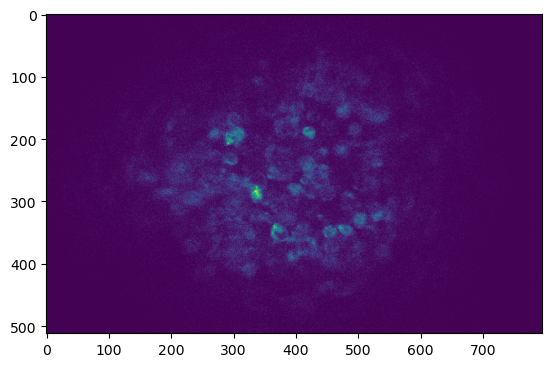

In [9]:
plt.imshow(loaded_stack_f[15,0,...])

In [11]:
Path(f'{base_path}{paths[0]}').stem[-7:]

'1_merge'

In [12]:
from tqdm.auto import trange
from collections import defaultdict
# bounds = (160,620,72,451)#x_st,x_en,y_st,y_en
# jumps = [2,4,8,10,15,20,30,40]
# funs = ['mean', 'max', 'median']
# regs = ['RIGID_BODY','AFFINE']
# filters_pipe = [ '', {'gaus':10,'med':15}]
# chs = [0]
# debug_f = ''#sig'


#bounds = (160,670,21,471) #x_st,x_en,y_st,y_en ignore a lot of the pixel around <-- select center of FOV.
#jumps = [40] # how many frames to mean <-- will repeat multiple times for each value if this is list (e.g. for every size of means)
#jumps = [39,26,52]
funs = ['mean'] # which function to use | mean | max | median <-- can be a list also
#regs = ['']#['AFFINE', 'RIGID_BODY'] # register? probabbly not needed. either <-- 2D, sequential, StackReg within each jump set
#filters_pipe = [ '']#{'gaus':10,'med':15}] <-- blurring for registration
chs = [0,1] #1 is red, 0 is green

#till 164!
#sbx_to_stack = defaultdict(list)
# !!!
# those are available - regist_stack_parallel,filter_data_parallel
#load_stack = stack_loader()
for ch in chs:
    for p in trange(0,len(paths)):
        read_path = Path(f'{base_path}{paths[p]}')
        if read_path.stem[-8:] == '001_full':
            save_folder = read_path.parent / f'wells001/segtrack/tiffs/ch{ch}'
        elif read_path.stem[-8:] == '100_full':
            save_folder = read_path.parent / f'wells100/segtrack/tiffs/ch{ch}'
        elif read_path.stem[-8:] == '101_full':
            save_folder = read_path.parent / f'wells101/segtrack/tiffs/ch{ch}'
        elif read_path.stem[-8:] == '201_full':
            save_folder = read_path.parent / f'wells201/segtrack/tiffs/ch{ch}'
        elif read_path.stem[-8:] == '301_full':
            save_folder = read_path.parent / f'wells301/segtrack/tiffs/ch{ch}'
        elif read_path.stem[-8:] == '401_full':
            save_folder = read_path.parent / f'wells401/segtrack/tiffs/ch{ch}'
        elif read_path.stem[-8:] == '501_full':
            save_folder = read_path.parent / f'wells501/segtrack/tiffs/ch{ch}'
        elif read_path.stem[-8:] == '601_full':
            save_folder = read_path.parent / f'wells601/segtrack/tiffs/ch{ch}'
        elif read_path.stem[-8:] == '701_full':
            save_folder = read_path.parent / f'wells701/segtrack/tiffs/ch{ch}'
        elif read_path.stem[-3:] == '002':
            save_folder = read_path.parent / f'mouse2/segtrack/tiffs/ch{ch}'
        elif read_path.stem[-7:] == '1_merge':
            save_folder = read_path.parent / f'well1/segtrack/tiffs/ch{ch}'
        elif read_path.stem[-7:] == '2_merge':
            save_folder = read_path.parent / f'well2/segtrack/tiffs/ch{ch}'
        elif read_path.stem[-7:] == '3_merge':
            save_folder = read_path.parent / f'well3/segtrack/tiffs/ch{ch}'
        elif read_path.stem[-7:] == '4_merge':
            save_folder = read_path.parent / f'well4/segtrack/tiffs/ch{ch}'
        elif read_path.stem[-7:] == '5_merge':
            save_folder = read_path.parent / f'well5/segtrack/tiffs/ch{ch}'
        elif read_path.stem[-7:] == '6_merge':
            save_folder = read_path.parent / f'well6/segtrack/tiffs/ch{ch}'
        elif read_path.stem[-7:] == '7_merge':
            save_folder = read_path.parent / f'well7/segtrack/tiffs/ch{ch}'
        elif read_path.stem[-7:] == '8_merge':
            save_folder = read_path.parent / f'well8/segtrack/tiffs/ch{ch}'
        elif read_path.stem[-7:] == '9_merge':
            save_folder = read_path.parent / f'well9/segtrack/tiffs/ch{ch}'
        else:
            save_folder = read_path.parent / f'mouse/segtrack/tiffs/ch{ch}'
        print(save_folder)
        stack_n = 0
        dat = sbx_memmap(read_path)
        r_st = 1
        r_en = int(dat.shape[0])
        jump = jumps[p]
        print(dat.shape, list(range(r_st, r_en, jump)))
        for i in trange(r_st, r_en, jump):
            print(i-1,i+jump-1)
            if (dat.shape[0]-i-1)<20: #excess frames to remove
                print("Skip, !!")
                continue
            stack = np.array(dat[i-1:i+jump-1,:,ch,bounds[p][2]:bounds[p][3],bounds[p][0]:bounds[p][1]])
            stack_n +=1

            for fun in funs:
                #print('C')
                loaded_stack_f = apply_func(stack, fun)

                funcs_path = fr'{jumps[p]}_{fun}__fix'.replace(' ','').replace(':','').replace("'",'')
                full_save_path = Path(fr'{save_folder}/{funcs_path}/')
                full_save_path.mkdir(parents=True, exist_ok=True )
                os.makedirs(full_save_path,exist_ok=True,)
                print(full_save_path / f'image{stack_n:03}.tiff')
                tif_imwrite(full_save_path / f'image{stack_n:03}.tiff', loaded_stack_f)
        
        

  0%|          | 0/54 [00:00<?, ?it/s]

\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well1\segtrack\tiffs\ch0
(1200, 30, 2, 512, 796) [1, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101, 111, 121, 131, 141, 151, 161, 171, 181, 191, 201, 211, 221, 231, 241, 251, 261, 271, 281, 291, 301, 311, 321, 331, 341, 351, 361, 371, 381, 391, 401, 411, 421, 431, 441, 451, 461, 471, 481, 491, 501, 511, 521, 531, 541, 551, 561, 571, 581, 591, 601, 611, 621, 631, 641, 651, 661, 671, 681, 691, 701, 711, 721, 731, 741, 751, 761, 771, 781, 791, 801, 811, 821, 831, 841, 851, 861, 871, 881, 891, 901, 911, 921, 931, 941, 951, 961, 971, 981, 991, 1001, 1011, 1021, 1031, 1041, 1051, 1061, 1071, 1081, 1091, 1101, 1111, 1121, 1131, 1141, 1151, 1161, 1171, 1181, 1191]


  0%|          | 0/120 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well1\segtrack\tiffs\ch0\10

\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image078.tiff
780 790
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image079.tiff
790 800
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well1\segtrack\t

  0%|          | 0/120 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well2\segtrack\tiffs\ch0\10

\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image078.tiff
780 790
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image079.tiff
790 800
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well2\segtrack\t

  0%|          | 0/120 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well3\segtrack\tiffs\ch0\10

\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image078.tiff
780 790
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image079.tiff
790 800
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well3\segtrack\t

  0%|          | 0/120 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well4\segtrack\tiffs\ch0\10

\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image078.tiff
780 790
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image079.tiff
790 800
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well4\segtrack\t

  0%|          | 0/120 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well5\segtrack\tiffs\ch0\10

\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image078.tiff
780 790
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image079.tiff
790 800
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well5\segtrack\t

  0%|          | 0/120 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well6\segtrack\tiffs\ch0\10

\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image078.tiff
780 790
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image079.tiff
790 800
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well6\segtrack\t

  0%|          | 0/120 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well1\segtrack\tiffs\ch0\10

\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image078.tiff
780 790
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image079.tiff
790 800
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well1\segtrack\t

  0%|          | 0/120 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well2\segtrack\tiffs\ch0\10

\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image078.tiff
780 790
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image079.tiff
790 800
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well2\segtrack\t

  0%|          | 0/120 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well3\segtrack\tiffs\ch0\10

\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image078.tiff
780 790
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image079.tiff
790 800
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well3\segtrack\t

  0%|          | 0/120 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well4\segtrack\tiffs\ch0\10

\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image078.tiff
780 790
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image079.tiff
790 800
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well4\segtrack\t

  0%|          | 0/120 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well5\segtrack\tiffs\ch0\10

\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image078.tiff
780 790
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image079.tiff
790 800
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well5\segtrack\t

  0%|          | 0/120 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well6\segtrack\tiffs\ch0\10

\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image078.tiff
780 790
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image079.tiff
790 800
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well6\segtrack\t

  0%|          | 0/120 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well1\segtrack\tiffs\ch0\10

\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image078.tiff
780 790
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image079.tiff
790 800
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well1\segtrack\t

  0%|          | 0/120 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well2\segtrack\tiffs\ch0\10

\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image078.tiff
780 790
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image079.tiff
790 800
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well2\segtrack\t

  0%|          | 0/120 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well3\segtrack\tiffs\ch0\10

\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image078.tiff
780 790
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image079.tiff
790 800
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well3\segtrack\t

  0%|          | 0/120 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well4\segtrack\tiffs\ch0\10

\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image078.tiff
780 790
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image079.tiff
790 800
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well4\segtrack\t

  0%|          | 0/120 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well5\segtrack\tiffs\ch0\10

\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image078.tiff
780 790
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image079.tiff
790 800
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well5\segtrack\t

  0%|          | 0/120 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well6\segtrack\tiffs\ch0\10

\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image078.tiff
780 790
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image079.tiff
790 800
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well6\segtrack\t

  0%|          | 0/120 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well1\segtrack\tiffs\ch0\10

\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image078.tiff
780 790
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image079.tiff
790 800
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well1\segtrack\t

  0%|          | 0/120 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well2\segtrack\tiffs\ch0\10

\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image078.tiff
780 790
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image079.tiff
790 800
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well2\segtrack\t

  0%|          | 0/120 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well3\segtrack\tiffs\ch0\10

\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image078.tiff
780 790
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image079.tiff
790 800
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well3\segtrack\t

  0%|          | 0/120 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well4\segtrack\tiffs\ch0\10

\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image078.tiff
780 790
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image079.tiff
790 800
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well4\segtrack\t

  0%|          | 0/120 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well5\segtrack\tiffs\ch0\10

\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image078.tiff
780 790
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image079.tiff
790 800
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well5\segtrack\t

  0%|          | 0/120 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well6\segtrack\tiffs\ch0\10

\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image078.tiff
780 790
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image079.tiff
790 800
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well6\segtrack\t

  0%|          | 0/120 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well1\segtrack\tiffs\ch0\10

\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image078.tiff
780 790
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image079.tiff
790 800
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well1\segtrack\t

  0%|          | 0/120 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well2\segtrack\tiffs\ch0\10

\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image078.tiff
780 790
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image079.tiff
790 800
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well2\segtrack\t

  0%|          | 0/120 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well3\segtrack\tiffs\ch0\10

\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image078.tiff
780 790
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image079.tiff
790 800
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well3\segtrack\t

  0%|          | 0/120 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well4\segtrack\tiffs\ch0\10

\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image078.tiff
780 790
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image079.tiff
790 800
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well4\segtrack\t

  0%|          | 0/120 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well5\segtrack\tiffs\ch0\10

\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image078.tiff
780 790
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image079.tiff
790 800
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well5\segtrack\t

  0%|          | 0/120 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well6\segtrack\tiffs\ch0\10

710 720
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image078.tiff
780 790
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image079.tiff
790 800
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well6\se

  0%|          | 0/120 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well1\segtrack\tiffs\ch0\10

\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image078.tiff
780 790
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image079.tiff
790 800
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well1\segtrack\t

  0%|          | 0/120 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well2\segtrack\tiffs\ch0\10

\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image078.tiff
780 790
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image079.tiff
790 800
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well2\segtrack\t

  0%|          | 0/120 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well3\segtrack\tiffs\ch0\10

\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image078.tiff
780 790
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image079.tiff
790 800
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well3\segtrack\t

  0%|          | 0/120 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well4\segtrack\tiffs\ch0\10

\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image078.tiff
780 790
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image079.tiff
790 800
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well4\segtrack\t

  0%|          | 0/120 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well5\segtrack\tiffs\ch0\10

\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image078.tiff
780 790
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image079.tiff
790 800
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well5\segtrack\t

  0%|          | 0/120 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well6\segtrack\tiffs\ch0\10

\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image078.tiff
780 790
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image079.tiff
790 800
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well6\segtrack\t

  0%|          | 0/80 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well1\segtrack\tiffs\ch0\10

\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image078.tiff
780 790
Skip, !!
790 800
Skip, !!
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well2\segtrack\tiffs\ch0
(800, 30, 2, 512, 796) [1, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101, 111, 121, 131

  0%|          | 0/80 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well2\segtrack\tiffs\ch0\10

\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image078.tiff
780 790
Skip, !!
790 800
Skip, !!
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well3\segtrack\tiffs\ch0
(800, 30, 2, 512, 796) [1, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101, 111, 121, 131

  0%|          | 0/80 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well3\segtrack\tiffs\ch0\10

\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image078.tiff
780 790
Skip, !!
790 800
Skip, !!
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well4\segtrack\tiffs\ch0
(800, 30, 2, 512, 796) [1, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101, 111, 121, 131

  0%|          | 0/80 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well4\segtrack\tiffs\ch0\10

\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image078.tiff
780 790
Skip, !!
790 800
Skip, !!
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well5\segtrack\tiffs\ch0
(800, 30, 2, 512, 796) [1, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101, 111, 121, 131

  0%|          | 0/80 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well5\segtrack\tiffs\ch0\10

\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image078.tiff
780 790
Skip, !!
790 800
Skip, !!
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well6\segtrack\tiffs\ch0
(800, 30, 2, 512, 796) [1, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101, 111, 121, 131

  0%|          | 0/80 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well6\segtrack\tiffs\ch0\10

\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image078.tiff
780 790
Skip, !!
790 800
Skip, !!
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well7\segtrack\tiffs\ch0
(800, 30, 2, 512, 796) [1, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101, 111, 121, 131

  0%|          | 0/80 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well7\segtrack\tiffs\ch0\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well7\segtrack\tiffs\ch0\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well7\segtrack\tiffs\ch0\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well7\segtrack\tiffs\ch0\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well7\segtrack\tiffs\ch0\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well7\segtrack\tiffs\ch0\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well7\segtrack\tiffs\ch0\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well7\segtrack\tiffs\ch0\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well7\segtrack\tiffs\ch0\10

\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well7\segtrack\tiffs\ch0\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well7\segtrack\tiffs\ch0\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well7\segtrack\tiffs\ch0\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well7\segtrack\tiffs\ch0\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well7\segtrack\tiffs\ch0\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well7\segtrack\tiffs\ch0\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well7\segtrack\tiffs\ch0\10_mean__fix\image078.tiff
780 790
Skip, !!
790 800
Skip, !!
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well8\segtrack\tiffs\ch0
(800, 30, 2, 512, 796) [1, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101, 111, 121, 131

  0%|          | 0/80 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well8\segtrack\tiffs\ch0\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well8\segtrack\tiffs\ch0\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well8\segtrack\tiffs\ch0\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well8\segtrack\tiffs\ch0\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well8\segtrack\tiffs\ch0\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well8\segtrack\tiffs\ch0\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well8\segtrack\tiffs\ch0\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well8\segtrack\tiffs\ch0\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well8\segtrack\tiffs\ch0\10

\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well8\segtrack\tiffs\ch0\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well8\segtrack\tiffs\ch0\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well8\segtrack\tiffs\ch0\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well8\segtrack\tiffs\ch0\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well8\segtrack\tiffs\ch0\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well8\segtrack\tiffs\ch0\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well8\segtrack\tiffs\ch0\10_mean__fix\image078.tiff
780 790
Skip, !!
790 800
Skip, !!
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well9\segtrack\tiffs\ch0
(800, 30, 2, 512, 796) [1, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101, 111, 121, 131

  0%|          | 0/80 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well9\segtrack\tiffs\ch0\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well9\segtrack\tiffs\ch0\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well9\segtrack\tiffs\ch0\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well9\segtrack\tiffs\ch0\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well9\segtrack\tiffs\ch0\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well9\segtrack\tiffs\ch0\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well9\segtrack\tiffs\ch0\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well9\segtrack\tiffs\ch0\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well9\segtrack\tiffs\ch0\10

\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well9\segtrack\tiffs\ch0\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well9\segtrack\tiffs\ch0\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well9\segtrack\tiffs\ch0\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well9\segtrack\tiffs\ch0\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well9\segtrack\tiffs\ch0\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well9\segtrack\tiffs\ch0\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well9\segtrack\tiffs\ch0\10_mean__fix\image078.tiff
780 790
Skip, !!
790 800
Skip, !!
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well1\segtrack\tiffs\ch0
(800, 30, 2, 512, 796) [1, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101, 111, 121, 131

  0%|          | 0/80 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well1\segtrack\tiffs\ch0\10

\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well1\segtrack\tiffs\ch0\10_mean__fix\image078.tiff
780 790
Skip, !!
790 800
Skip, !!
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well2\segtrack\tiffs\ch0
(800, 30, 2, 512, 796) [1, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101, 111, 121, 131

  0%|          | 0/80 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well2\segtrack\tiffs\ch0\10

\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well2\segtrack\tiffs\ch0\10_mean__fix\image078.tiff
780 790
Skip, !!
790 800
Skip, !!
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well3\segtrack\tiffs\ch0
(800, 30, 2, 512, 796) [1, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101, 111, 121, 131

  0%|          | 0/80 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well3\segtrack\tiffs\ch0\10

\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well3\segtrack\tiffs\ch0\10_mean__fix\image078.tiff
780 790
Skip, !!
790 800
Skip, !!
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well4\segtrack\tiffs\ch0
(800, 30, 2, 512, 796) [1, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101, 111, 121, 131

  0%|          | 0/80 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well4\segtrack\tiffs\ch0\10

\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well4\segtrack\tiffs\ch0\10_mean__fix\image078.tiff
780 790
Skip, !!
790 800
Skip, !!
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well5\segtrack\tiffs\ch0
(800, 30, 2, 512, 796) [1, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101, 111, 121, 131

  0%|          | 0/80 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well5\segtrack\tiffs\ch0\10

\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well5\segtrack\tiffs\ch0\10_mean__fix\image078.tiff
780 790
Skip, !!
790 800
Skip, !!
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well6\segtrack\tiffs\ch0
(800, 30, 2, 512, 796) [1, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101, 111, 121, 131

  0%|          | 0/80 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well6\segtrack\tiffs\ch0\10

\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well6\segtrack\tiffs\ch0\10_mean__fix\image078.tiff
780 790
Skip, !!
790 800
Skip, !!
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well7\segtrack\tiffs\ch0
(800, 30, 2, 512, 796) [1, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101, 111, 121, 131

  0%|          | 0/80 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well7\segtrack\tiffs\ch0\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well7\segtrack\tiffs\ch0\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well7\segtrack\tiffs\ch0\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well7\segtrack\tiffs\ch0\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well7\segtrack\tiffs\ch0\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well7\segtrack\tiffs\ch0\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well7\segtrack\tiffs\ch0\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well7\segtrack\tiffs\ch0\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well7\segtrack\tiffs\ch0\10

\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well7\segtrack\tiffs\ch0\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well7\segtrack\tiffs\ch0\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well7\segtrack\tiffs\ch0\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well7\segtrack\tiffs\ch0\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well7\segtrack\tiffs\ch0\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well7\segtrack\tiffs\ch0\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well7\segtrack\tiffs\ch0\10_mean__fix\image078.tiff
780 790
Skip, !!
790 800
Skip, !!
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well8\segtrack\tiffs\ch0
(800, 30, 2, 512, 796) [1, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101, 111, 121, 131

  0%|          | 0/80 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well8\segtrack\tiffs\ch0\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well8\segtrack\tiffs\ch0\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well8\segtrack\tiffs\ch0\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well8\segtrack\tiffs\ch0\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well8\segtrack\tiffs\ch0\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well8\segtrack\tiffs\ch0\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well8\segtrack\tiffs\ch0\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well8\segtrack\tiffs\ch0\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well8\segtrack\tiffs\ch0\10

\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well8\segtrack\tiffs\ch0\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well8\segtrack\tiffs\ch0\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well8\segtrack\tiffs\ch0\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well8\segtrack\tiffs\ch0\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well8\segtrack\tiffs\ch0\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well8\segtrack\tiffs\ch0\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well8\segtrack\tiffs\ch0\10_mean__fix\image078.tiff
780 790
Skip, !!
790 800
Skip, !!
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well9\segtrack\tiffs\ch0
(800, 30, 2, 512, 796) [1, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101, 111, 121, 131

  0%|          | 0/80 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well9\segtrack\tiffs\ch0\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well9\segtrack\tiffs\ch0\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well9\segtrack\tiffs\ch0\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well9\segtrack\tiffs\ch0\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well9\segtrack\tiffs\ch0\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well9\segtrack\tiffs\ch0\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well9\segtrack\tiffs\ch0\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well9\segtrack\tiffs\ch0\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well9\segtrack\tiffs\ch0\10

\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well9\segtrack\tiffs\ch0\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well9\segtrack\tiffs\ch0\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well9\segtrack\tiffs\ch0\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well9\segtrack\tiffs\ch0\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well9\segtrack\tiffs\ch0\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well9\segtrack\tiffs\ch0\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well9\segtrack\tiffs\ch0\10_mean__fix\image078.tiff
780 790
Skip, !!
790 800
Skip, !!


  0%|          | 0/54 [00:00<?, ?it/s]

\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well1\segtrack\tiffs\ch1
(1200, 30, 2, 512, 796) [1, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101, 111, 121, 131, 141, 151, 161, 171, 181, 191, 201, 211, 221, 231, 241, 251, 261, 271, 281, 291, 301, 311, 321, 331, 341, 351, 361, 371, 381, 391, 401, 411, 421, 431, 441, 451, 461, 471, 481, 491, 501, 511, 521, 531, 541, 551, 561, 571, 581, 591, 601, 611, 621, 631, 641, 651, 661, 671, 681, 691, 701, 711, 721, 731, 741, 751, 761, 771, 781, 791, 801, 811, 821, 831, 841, 851, 861, 871, 881, 891, 901, 911, 921, 931, 941, 951, 961, 971, 981, 991, 1001, 1011, 1021, 1031, 1041, 1051, 1061, 1071, 1081, 1091, 1101, 1111, 1121, 1131, 1141, 1151, 1161, 1171, 1181, 1191]


  0%|          | 0/120 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well1\segtrack\tiffs\ch1\10

\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image078.tiff
780 790
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image079.tiff
790 800
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well1\segtrack\t

  0%|          | 0/120 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well2\segtrack\tiffs\ch1\10

\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image078.tiff
780 790
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image079.tiff
790 800
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well2\segtrack\t

  0%|          | 0/120 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well3\segtrack\tiffs\ch1\10

\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image078.tiff
780 790
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image079.tiff
790 800
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well3\segtrack\t

  0%|          | 0/120 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well4\segtrack\tiffs\ch1\10

\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image078.tiff
780 790
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image079.tiff
790 800
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well4\segtrack\t

  0%|          | 0/120 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well5\segtrack\tiffs\ch1\10

\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image078.tiff
780 790
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image079.tiff
790 800
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well5\segtrack\t

  0%|          | 0/120 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well6\segtrack\tiffs\ch1\10

\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image078.tiff
780 790
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image079.tiff
790 800
\\NASQUATCH\data\2p\peter\chip_tiling\211103_PZ1\chunks\well6\segtrack\t

  0%|          | 0/120 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well1\segtrack\tiffs\ch1\10

\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image078.tiff
780 790
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image079.tiff
790 800
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well1\segtrack\t

  0%|          | 0/120 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well2\segtrack\tiffs\ch1\10

\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image078.tiff
780 790
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image079.tiff
790 800
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well2\segtrack\t

  0%|          | 0/120 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well3\segtrack\tiffs\ch1\10

\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image078.tiff
780 790
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image079.tiff
790 800
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well3\segtrack\t

  0%|          | 0/120 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well4\segtrack\tiffs\ch1\10

\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image078.tiff
780 790
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image079.tiff
790 800
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well4\segtrack\t

  0%|          | 0/120 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well5\segtrack\tiffs\ch1\10

\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image078.tiff
780 790
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image079.tiff
790 800
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well5\segtrack\t

  0%|          | 0/120 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well6\segtrack\tiffs\ch1\10

\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image078.tiff
780 790
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image079.tiff
790 800
\\NASQUATCH\data\2p\peter\chip_tiling\211104_PZ1\chunks\well6\segtrack\t

  0%|          | 0/120 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well1\segtrack\tiffs\ch1\10

\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image078.tiff
780 790
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image079.tiff
790 800
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well1\segtrack\t

  0%|          | 0/120 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well2\segtrack\tiffs\ch1\10

\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image078.tiff
780 790
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image079.tiff
790 800
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well2\segtrack\t

  0%|          | 0/120 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well3\segtrack\tiffs\ch1\10

\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image078.tiff
780 790
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image079.tiff
790 800
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well3\segtrack\t

  0%|          | 0/120 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well4\segtrack\tiffs\ch1\10

\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image078.tiff
780 790
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image079.tiff
790 800
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well4\segtrack\t

  0%|          | 0/120 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well5\segtrack\tiffs\ch1\10

\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image078.tiff
780 790
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image079.tiff
790 800
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well5\segtrack\t

  0%|          | 0/120 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well6\segtrack\tiffs\ch1\10

\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image078.tiff
780 790
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image079.tiff
790 800
\\NASQUATCH\data\2p\peter\chip_tiling\211109_PZ1\chunks\well6\segtrack\t

  0%|          | 0/120 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well1\segtrack\tiffs\ch1\10

\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image078.tiff
780 790
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image079.tiff
790 800
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well1\segtrack\t

  0%|          | 0/120 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well2\segtrack\tiffs\ch1\10

\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image078.tiff
780 790
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image079.tiff
790 800
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well2\segtrack\t

  0%|          | 0/120 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well3\segtrack\tiffs\ch1\10

\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image078.tiff
780 790
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image079.tiff
790 800
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well3\segtrack\t

  0%|          | 0/120 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well4\segtrack\tiffs\ch1\10

\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image078.tiff
780 790
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image079.tiff
790 800
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well4\segtrack\t

  0%|          | 0/120 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well5\segtrack\tiffs\ch1\10

\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image078.tiff
780 790
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image079.tiff
790 800
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well5\segtrack\t

  0%|          | 0/120 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well6\segtrack\tiffs\ch1\10

\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image078.tiff
780 790
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image079.tiff
790 800
\\NASQUATCH\data\2p\peter\chip_tiling\211110_PZ1\chunks\well6\segtrack\t

  0%|          | 0/120 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well1\segtrack\tiffs\ch1\10

\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image078.tiff
780 790
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image079.tiff
790 800
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well1\segtrack\t

  0%|          | 0/120 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well2\segtrack\tiffs\ch1\10

\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image078.tiff
780 790
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image079.tiff
790 800
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well2\segtrack\t

  0%|          | 0/120 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well3\segtrack\tiffs\ch1\10

\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image078.tiff
780 790
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image079.tiff
790 800
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well3\segtrack\t

  0%|          | 0/120 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well4\segtrack\tiffs\ch1\10

\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image078.tiff
780 790
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image079.tiff
790 800
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well4\segtrack\t

  0%|          | 0/120 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well5\segtrack\tiffs\ch1\10

\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image078.tiff
780 790
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image079.tiff
790 800
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well5\segtrack\t

  0%|          | 0/120 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well6\segtrack\tiffs\ch1\10

\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image078.tiff
780 790
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image079.tiff
790 800
\\NASQUATCH\data\2p\peter\chip_tiling\211111_PZ1\chunks\well6\segtrack\t

  0%|          | 0/120 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well1\segtrack\tiffs\ch1\10

\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image078.tiff
780 790
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image079.tiff
790 800
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well1\segtrack\t

  0%|          | 0/120 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well2\segtrack\tiffs\ch1\10

\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image078.tiff
780 790
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image079.tiff
790 800
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well2\segtrack\t

  0%|          | 0/120 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well3\segtrack\tiffs\ch1\10

\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image078.tiff
780 790
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image079.tiff
790 800
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well3\segtrack\t

  0%|          | 0/120 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well4\segtrack\tiffs\ch1\10

\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image078.tiff
780 790
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image079.tiff
790 800
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well4\segtrack\t

  0%|          | 0/120 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well5\segtrack\tiffs\ch1\10

\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image078.tiff
780 790
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image079.tiff
790 800
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well5\segtrack\t

  0%|          | 0/120 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well6\segtrack\tiffs\ch1\10

\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image078.tiff
780 790
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image079.tiff
790 800
\\NASQUATCH\data\2p\peter\chip_tiling\211112_PZ1\chunks\well6\segtrack\t

  0%|          | 0/80 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well1\segtrack\tiffs\ch1\10

\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image078.tiff
780 790
Skip, !!
790 800
Skip, !!
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well2\segtrack\tiffs\ch1
(800, 30, 2, 512, 796) [1, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101, 111, 121, 131

  0%|          | 0/80 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well2\segtrack\tiffs\ch1\10

\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image078.tiff
780 790
Skip, !!
790 800
Skip, !!
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well3\segtrack\tiffs\ch1
(800, 30, 2, 512, 796) [1, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101, 111, 121, 131

  0%|          | 0/80 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well3\segtrack\tiffs\ch1\10

\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image078.tiff
780 790
Skip, !!
790 800
Skip, !!
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well4\segtrack\tiffs\ch1
(800, 30, 2, 512, 796) [1, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101, 111, 121, 131

  0%|          | 0/80 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well4\segtrack\tiffs\ch1\10

\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image078.tiff
780 790
Skip, !!
790 800
Skip, !!
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well5\segtrack\tiffs\ch1
(800, 30, 2, 512, 796) [1, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101, 111, 121, 131

  0%|          | 0/80 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well5\segtrack\tiffs\ch1\10

\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image078.tiff
780 790
Skip, !!
790 800
Skip, !!
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well6\segtrack\tiffs\ch1
(800, 30, 2, 512, 796) [1, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101, 111, 121, 131

  0%|          | 0/80 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well6\segtrack\tiffs\ch1\10

\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image078.tiff
780 790
Skip, !!
790 800
Skip, !!
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well7\segtrack\tiffs\ch1
(800, 30, 2, 512, 796) [1, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101, 111, 121, 131

  0%|          | 0/80 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well7\segtrack\tiffs\ch1\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well7\segtrack\tiffs\ch1\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well7\segtrack\tiffs\ch1\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well7\segtrack\tiffs\ch1\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well7\segtrack\tiffs\ch1\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well7\segtrack\tiffs\ch1\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well7\segtrack\tiffs\ch1\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well7\segtrack\tiffs\ch1\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well7\segtrack\tiffs\ch1\10

\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well7\segtrack\tiffs\ch1\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well7\segtrack\tiffs\ch1\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well7\segtrack\tiffs\ch1\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well7\segtrack\tiffs\ch1\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well7\segtrack\tiffs\ch1\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well7\segtrack\tiffs\ch1\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well7\segtrack\tiffs\ch1\10_mean__fix\image078.tiff
780 790
Skip, !!
790 800
Skip, !!
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well8\segtrack\tiffs\ch1
(800, 30, 2, 512, 796) [1, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101, 111, 121, 131

  0%|          | 0/80 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well8\segtrack\tiffs\ch1\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well8\segtrack\tiffs\ch1\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well8\segtrack\tiffs\ch1\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well8\segtrack\tiffs\ch1\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well8\segtrack\tiffs\ch1\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well8\segtrack\tiffs\ch1\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well8\segtrack\tiffs\ch1\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well8\segtrack\tiffs\ch1\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well8\segtrack\tiffs\ch1\10

\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well8\segtrack\tiffs\ch1\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well8\segtrack\tiffs\ch1\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well8\segtrack\tiffs\ch1\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well8\segtrack\tiffs\ch1\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well8\segtrack\tiffs\ch1\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well8\segtrack\tiffs\ch1\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well8\segtrack\tiffs\ch1\10_mean__fix\image078.tiff
780 790
Skip, !!
790 800
Skip, !!
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well9\segtrack\tiffs\ch1
(800, 30, 2, 512, 796) [1, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101, 111, 121, 131

  0%|          | 0/80 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well9\segtrack\tiffs\ch1\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well9\segtrack\tiffs\ch1\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well9\segtrack\tiffs\ch1\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well9\segtrack\tiffs\ch1\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well9\segtrack\tiffs\ch1\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well9\segtrack\tiffs\ch1\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well9\segtrack\tiffs\ch1\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well9\segtrack\tiffs\ch1\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well9\segtrack\tiffs\ch1\10

\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well9\segtrack\tiffs\ch1\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well9\segtrack\tiffs\ch1\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well9\segtrack\tiffs\ch1\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well9\segtrack\tiffs\ch1\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well9\segtrack\tiffs\ch1\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well9\segtrack\tiffs\ch1\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211121_PZ1\chunks\well9\segtrack\tiffs\ch1\10_mean__fix\image078.tiff
780 790
Skip, !!
790 800
Skip, !!
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well1\segtrack\tiffs\ch1
(800, 30, 2, 512, 796) [1, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101, 111, 121, 131

  0%|          | 0/80 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well1\segtrack\tiffs\ch1\10

\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well1\segtrack\tiffs\ch1\10_mean__fix\image078.tiff
780 790
Skip, !!
790 800
Skip, !!
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well2\segtrack\tiffs\ch1
(800, 30, 2, 512, 796) [1, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101, 111, 121, 131

  0%|          | 0/80 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well2\segtrack\tiffs\ch1\10

\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well2\segtrack\tiffs\ch1\10_mean__fix\image078.tiff
780 790
Skip, !!
790 800
Skip, !!
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well3\segtrack\tiffs\ch1
(800, 30, 2, 512, 796) [1, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101, 111, 121, 131

  0%|          | 0/80 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well3\segtrack\tiffs\ch1\10

\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well3\segtrack\tiffs\ch1\10_mean__fix\image078.tiff
780 790
Skip, !!
790 800
Skip, !!
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well4\segtrack\tiffs\ch1
(800, 30, 2, 512, 796) [1, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101, 111, 121, 131

  0%|          | 0/80 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well4\segtrack\tiffs\ch1\10

\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well4\segtrack\tiffs\ch1\10_mean__fix\image078.tiff
780 790
Skip, !!
790 800
Skip, !!
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well5\segtrack\tiffs\ch1
(800, 30, 2, 512, 796) [1, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101, 111, 121, 131

  0%|          | 0/80 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well5\segtrack\tiffs\ch1\10

\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well5\segtrack\tiffs\ch1\10_mean__fix\image078.tiff
780 790
Skip, !!
790 800
Skip, !!
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well6\segtrack\tiffs\ch1
(800, 30, 2, 512, 796) [1, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101, 111, 121, 131

  0%|          | 0/80 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well6\segtrack\tiffs\ch1\10

\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well6\segtrack\tiffs\ch1\10_mean__fix\image078.tiff
780 790
Skip, !!
790 800
Skip, !!
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well7\segtrack\tiffs\ch1
(800, 30, 2, 512, 796) [1, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101, 111, 121, 131

  0%|          | 0/80 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well7\segtrack\tiffs\ch1\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well7\segtrack\tiffs\ch1\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well7\segtrack\tiffs\ch1\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well7\segtrack\tiffs\ch1\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well7\segtrack\tiffs\ch1\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well7\segtrack\tiffs\ch1\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well7\segtrack\tiffs\ch1\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well7\segtrack\tiffs\ch1\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well7\segtrack\tiffs\ch1\10

\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well7\segtrack\tiffs\ch1\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well7\segtrack\tiffs\ch1\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well7\segtrack\tiffs\ch1\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well7\segtrack\tiffs\ch1\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well7\segtrack\tiffs\ch1\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well7\segtrack\tiffs\ch1\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well7\segtrack\tiffs\ch1\10_mean__fix\image078.tiff
780 790
Skip, !!
790 800
Skip, !!
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well8\segtrack\tiffs\ch1
(800, 30, 2, 512, 796) [1, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101, 111, 121, 131

  0%|          | 0/80 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well8\segtrack\tiffs\ch1\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well8\segtrack\tiffs\ch1\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well8\segtrack\tiffs\ch1\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well8\segtrack\tiffs\ch1\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well8\segtrack\tiffs\ch1\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well8\segtrack\tiffs\ch1\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well8\segtrack\tiffs\ch1\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well8\segtrack\tiffs\ch1\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well8\segtrack\tiffs\ch1\10

\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well8\segtrack\tiffs\ch1\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well8\segtrack\tiffs\ch1\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well8\segtrack\tiffs\ch1\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well8\segtrack\tiffs\ch1\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well8\segtrack\tiffs\ch1\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well8\segtrack\tiffs\ch1\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well8\segtrack\tiffs\ch1\10_mean__fix\image078.tiff
780 790
Skip, !!
790 800
Skip, !!
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well9\segtrack\tiffs\ch1
(800, 30, 2, 512, 796) [1, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101, 111, 121, 131

  0%|          | 0/80 [00:00<?, ?it/s]

0 10
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well9\segtrack\tiffs\ch1\10_mean__fix\image001.tiff
10 20
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well9\segtrack\tiffs\ch1\10_mean__fix\image002.tiff
20 30
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well9\segtrack\tiffs\ch1\10_mean__fix\image003.tiff
30 40
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well9\segtrack\tiffs\ch1\10_mean__fix\image004.tiff
40 50
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well9\segtrack\tiffs\ch1\10_mean__fix\image005.tiff
50 60
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well9\segtrack\tiffs\ch1\10_mean__fix\image006.tiff
60 70
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well9\segtrack\tiffs\ch1\10_mean__fix\image007.tiff
70 80
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well9\segtrack\tiffs\ch1\10_mean__fix\image008.tiff
80 90
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well9\segtrack\tiffs\ch1\10

\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well9\segtrack\tiffs\ch1\10_mean__fix\image072.tiff
720 730
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well9\segtrack\tiffs\ch1\10_mean__fix\image073.tiff
730 740
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well9\segtrack\tiffs\ch1\10_mean__fix\image074.tiff
740 750
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well9\segtrack\tiffs\ch1\10_mean__fix\image075.tiff
750 760
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well9\segtrack\tiffs\ch1\10_mean__fix\image076.tiff
760 770
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well9\segtrack\tiffs\ch1\10_mean__fix\image077.tiff
770 780
\\NASQUATCH\data\2p\peter\chip_tiling\211123_PZ1\chunks\well9\segtrack\tiffs\ch1\10_mean__fix\image078.tiff
780 790
Skip, !!
790 800
Skip, !!


In [37]:
# Create big stack for iamges:
frame_start = 0
frame_end = 14

# tiffs  = []
masks = []
for i in trange(frame_start,frame_end):
#     tiffs.append(tif_imread(f'{mean_folder}/image{i:03}.tiff'))
    masks.append(tif_imread(f'{full_save_path}/image{i:03}.tiff'))
    
# tiffs = np.array(tiffs)
masks = np.array(masks)
tif_imsave(str(full_save_path)  + '_' + f'st{frame_start}en{frame_end}.tiff' , masks, imagej=True,metadata={'axes': 'TZYX'})


  0%|          | 0/14 [00:00<?, ?it/s]

<ipython-input-37-8b388ccea23d>:13: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tif_imsave(str(full_save_path)  + '_' + f'st{frame_start}en{frame_end}.tiff' , masks, imagej=True,metadata={'axes': 'TZYX'})


In [7]:
a =2
f'hhhhhyguyghuyg = {a}'

'hhhhhyguyghuyg = 2'

In [16]:
list(range(1,int(dat.shape[0]),jump))

[1, 41, 81, 121, 161]